In [1]:
import sys
from glob import glob

import time
import h5py
import zarr
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree

In [44]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

from datetime import datetime, timedelta

import dask.array as da

In [8]:
lead =2

In [3]:
def neighbour_leads(lead):
    out = [lead-2, lead-1, lead, lead+1]
    flag_shift = [0, 0, 0, 0]
    
    for i in range(4):
        if out[i] < 0:
            out[i] = 24+out[i]
            flag_shift[i] = -1
        if out[i] > 23:
            out[i] = out[i]-24
            flag_shift[i] = +1
            
    return out, flag_shift

means = [
    -6.335041783675384,
    101598.30648208999,
    2.4340308170812857,
    0.0238316214287872,
    0.0115228964831135,
    0.015723252607236175,
    0.00010298927478466365,
    0.00013315081911787703,
    0.02022990418418194,
    285.1588453352469,
    280.69456763975046,
    0.18025322895802864,
    -0.35625256772098957,
    4.466962100212334,
    0.10710428466431396,
    311.51020050786116,
    -22.95554152474839,
    95.80303950026172,
    41.22773039479408,
    2.696538199313979,
    0.257023643073863,
    11.80181492281666,
    0.15778718430103703,
];

stds = [
    8.872575669978966,
    672.3339463894478,
    7.555104640235371,
    0.5696550725786566,
    0.2283199203388272,
    0.37333362094670486,
    0.00022281640603195643,
    0.0002413561909874066,
    0.3589573748563584,
    11.553795616392204,
    12.101590155483459,
    3.1758721705443826,
    3.6588052023281175,
    2.6995797278745948,
    0.9896017905552607,
    748.8376068157106,
    78.895180023938,
    104.17948262883918*2,
    77.25788246299936*2,
    5.35086729614372,
    5.438075471238217,
    11.440203318938076,
    11.327741531273508
];

ind_pick = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]

log_norm = [True, False, True, True, True, True, True, True, True, False, False, 
            False, False, True, True, True, True, False, False, False, False, False, False]

sparse = [True, False, True, True, True, True, True, True, True, False, False, 
          False, False, False, True, True, True, False, False, False, False, False, False]


In [5]:
base_dir = '/glade/p/mmm/parc/sobash/NSC/3KM_WRF_POST_12sec_ts/'
nc_files = sorted(glob(base_dir+'*/*02_00_00.nc'))

In [9]:
lead_window, flag_shift = neighbour_leads(lead)

In [10]:
record_all = ()

for i, lead_temp in enumerate(lead_window):
    
    flag_ = flag_shift[i]
    
    with h5py.File(save_dir_scratch+'SPC_x_NCAR500_to_lead{}_72km_all.hdf'.format(lead_temp), 'r') as h5io:
        record_temp = h5io['record_v3'][...]
        
    if flag_shift[i] == 0:
        record_all = record_all + (record_temp,)
        
    if flag_shift[i] == -1:
        record_temp[1:, ...] = record_temp[:-1, ...]
        record_temp[0, ...] = np.nan
        record_all = record_all + (record_temp,)
    
    if flag_shift[i] == +1:
        record_temp[:-1, ...] = record_temp[1:, ...]
        record_temp[-1, ...] = np.nan
        record_all = record_all + (record_temp,)


shape_record = record_temp.shape      
record_v3 = np.empty(shape_record)
record_v3[...] = np.nan

for i in range(4):
    record_temp = record_all[i]
    for day in range(shape_record[0]):
        for ix in range(shape_record[1]):
            for iy in range(shape_record[2]):
                for event in range(shape_record[3]):
                    if np.logical_not(np.isnan(record_temp[day, ix, iy, event])):
                        record_v3[day, ix, iy, event] = record_temp[day, ix, iy, event]

In [31]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_72km = h5io['lon_80km'][...]
    lat_72km = h5io['lat_80km'][...]
    land_mask_72km = h5io['land_mask_80km'][...]

with h5py.File(save_dir+'NCAR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_ncar'][...]
    lat_3km = h5io['lat_ncar'][...]
    land_mask_3km = h5io['land_mask_ncar'][...]
    
# with h5py.File(save_dir+'HRRR_torn_monthly.hdf', 'r') as h5io:
#     clim = h5io['clim'][:]
    
shape_72km = lon_72km.shape
shape_3km = lon_3km.shape
shape_record = record_v3.shape

indx_array = np.empty(shape_72km)
indy_array = np.empty(shape_72km)

gridTree = cKDTree(list(zip(lon_3km.ravel(), lat_3km.ravel()))) #KDTree_wraper(xgrid, ygrid)

for xi in range(shape_72km[0]):
    for yi in range(shape_72km[1]):
        
        temp_lon = lon_72km[xi, yi]
        temp_lat = lat_72km[xi, yi]
        
        dist, indexes = gridTree.query(list(zip(np.array(temp_lon)[None], np.array(temp_lat)[None])))
        indx_3km, indy_3km = np.unravel_index(indexes, shape_3km)
        
        indx_array[xi, yi] = indx_3km[0]
        indy_array[xi, yi] = indy_3km[0]

In [49]:
L_train = 1838

input_size = 64
half_margin = 32

L_vars = len(ind_pick)
L_vars_per = len(ind_pick)

out_slice = np.empty((1, input_size, input_size, L_vars))

batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch_ncar/'
prefix = 'NCAR_{}_day{:04d}_{}_{}_{}_indx{}_indy{}_lead{}.npy'

flag_torn = 'neg'
flag_wind = 'neg'
flag_hail = 'neg'

var_list = ['REFL_COM', 'AFWA_MSLP', 'UP_HELI_MAX', 'UP_HELI_MAX03', 'GRPL_MAX', 'T2', 
            'TD2', 'WSPD10MAX', 'PREC_ACC_NC', 'SBCAPE', 'SBCINH', 'SRH03', 'SRH01', 'USHR6', 'VSHR6']

In [63]:
for day, nc_name in enumerate(nc_files[:1]):
    if day > L_train:
        tv_label = 'VALID'
    else:
        tv_label = 'TRAIN'

    dict_temp = {}

    with nc.Dataset(nc_name, 'r') as ncio:
        for i, var in enumerate(var_list):
            dict_temp[var] = np.array(ncio[var][0, ...])
        
    for ix in range(shape_72km[0]):
        for iy in range(shape_72km[1]):
            
            indx = int(indx_array[ix, iy])
            indy = int(indy_array[ix, iy])
            
            x_edge_left = indx - half_margin
            x_edge_right = indx + half_margin

            y_edge_bottom = indy - half_margin
            y_edge_top = indy + half_margin
            
            if x_edge_left >= 0 and y_edge_bottom >= 0 and x_edge_right < shape_3km[0] and y_edge_top < shape_3km[1]:

                if land_mask_3km[x_edge_left, y_edge_bottom] and land_mask_3km[x_edge_left, y_edge_top]:
                    
                    if land_mask_3km[x_edge_right, y_edge_bottom] and land_mask_3km[x_edge_right, y_edge_top]:
                        
                        #hrrr_3km = HRRRv3_lead[day, x_edge_left:x_edge_right, y_edge_bottom:y_edge_top, :]
                        
                        for v, ind_var in enumerate(ind_pick):

                            temp = dict_temp[var_list[v]][x_edge_left:x_edge_right, y_edge_bottom:y_edge_top]
                            
                            if ind_var == 0:
                                temp[temp<0] = 0

                            if log_norm[ind_var]:
                                temp = np.log(np.abs(temp)+1)
                            else:
                                temp = (temp - means[ind_var])/stds[ind_var]

                            out_slice[..., v] = temp

                        obs_temp = record_v3[day, ix, iy, :]

                        if obs_temp[0] == 0:
                            flag_torn = 'neg'
                        else:
                            flag_torn = 'pos'

                        if obs_temp[1] == 0:
                            flag_wind = 'neg'
                        else:
                            flag_wind = 'pos'

                        if obs_temp[2] == 0:
                            flag_hail = 'neg'
                        else:
                            flag_hail = 'pos' 

                        if np.sum(np.isnan(out_slice)) > 0:
                            print('HRRR contains NaN')
                            continue;
                        else:
                            save_name = batch_dir+prefix.format(tv_label, day, flag_torn, flag_wind, flag_hail, ix, iy, lead)
                            #if flag_hail == 'neg' and flag_wind=='neg':
                            print(save_name)
                                #aergqaeer
                                #np.save(save_name, out_slice)

/glade/scratch/ksha/DATA/NCAR_batch_ncar/NCAR_TRAIN_day0000_neg_neg_neg_indx13_indy48_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch_ncar/NCAR_TRAIN_day0000_neg_neg_neg_indx14_indy48_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch_ncar/NCAR_TRAIN_day0000_neg_neg_neg_indx15_indy47_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch_ncar/NCAR_TRAIN_day0000_neg_neg_neg_indx15_indy48_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch_ncar/NCAR_TRAIN_day0000_neg_neg_neg_indx15_indy49_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch_ncar/NCAR_TRAIN_day0000_neg_neg_neg_indx15_indy50_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch_ncar/NCAR_TRAIN_day0000_neg_neg_neg_indx15_indy58_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch_ncar/NCAR_TRAIN_day0000_neg_neg_neg_indx16_indy44_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch_ncar/NCAR_TRAIN_day0000_neg_neg_neg_indx16_indy46_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch_ncar/NCAR_TRAIN_day0000_neg_neg_neg_indx16_indy47_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch_ncar

In [67]:
np.mean(dict_temp[var_list[1]].ravel())

101476.484

In [78]:
out_slice = np.load('/glade/scratch/ksha/DATA/NCAR_batch_ncar/NCAR_TRAIN_day0000_neg_neg_neg_indx20_indy36_lead2.npy')

In [81]:
# for i in range(15):
#     plt.figure()
#     plt.hist(out_slice[..., i].ravel())
#     plt.title(var_list[i])

In [42]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

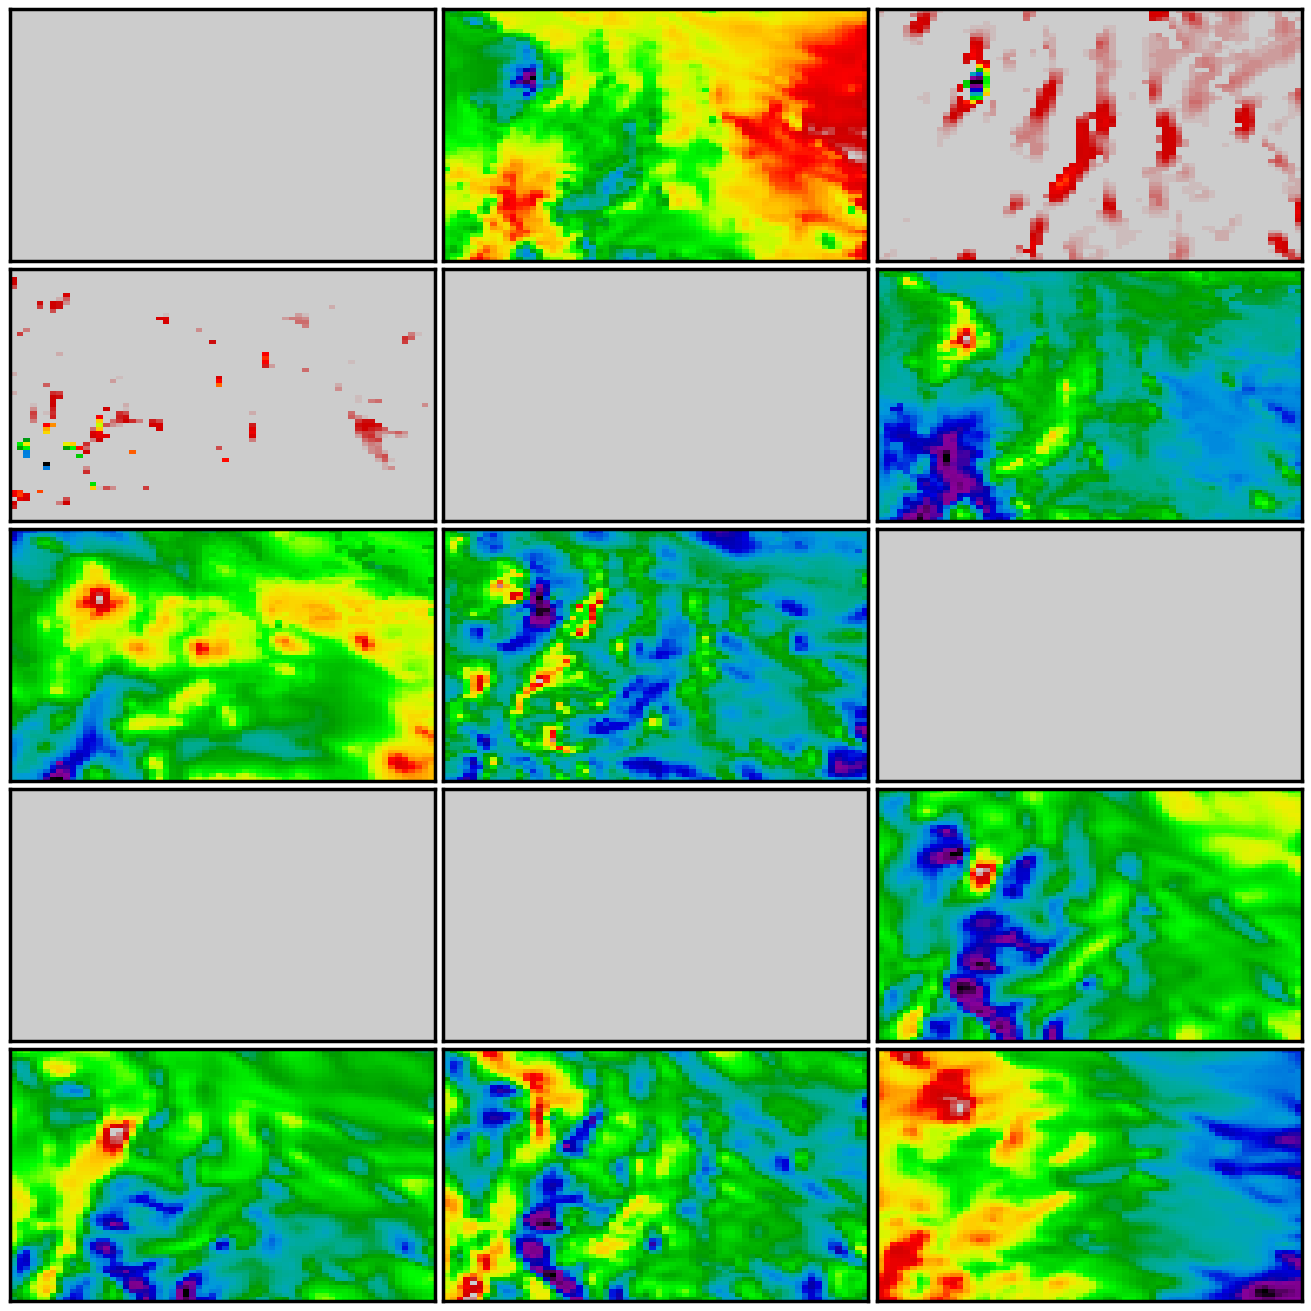

In [80]:
data = out_slice

fig, AX = plt.subplots(5, 3, figsize=(13, 13), constrained_layout=True)
AX = AX.ravel()
for i, ax in enumerate(AX):
    ax = gu.ax_decorate_box(ax)
    try:
        ax.pcolormesh(data[0, ..., i], cmap=plt.cm.nipy_spectral_r)
        ax.set_title(name_pick[i])
    except:
        continue